# 🧩 Cell 1: Imports and Logger Initialization

In [ ]:
cd ..

/home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1


In [ ]:
import os
import sys
import pandas as pd
from srcs.utils.logger import get_module_logger

# Get the current working directory and determine the project root
NOTEBOOK_DIR = os.getcwd()  # This gets the current working directory
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../../"))  # Move two directories up to the project root

# Add the project root to sys.path
sys.path.append(PROJECT_ROOT)

from srcs.utils.settings import (
    METADATA_PATH, REVIEWS_PATH, CLEANED_REVIEWS_PATH_CSV, 
    CLEANED_REVIEWS_PATH_PARQUET,FILTERED_METADATA_PATH_JSON, FILTERED_METADATA_PATH_CSV, FILTERED_METADATA_PATH_PARQUET
)

# Set up the logger
logger = get_module_logger("meta_cleaning")

In [4]:
reviews_df = pd.read_csv(CLEANED_REVIEWS_PATH_CSV)

# Display first few rows for a quick overview
print (" ----------- First 5 Rows of the Dataset -----------")
reviews_df.head(5)

 ----------- First 5 Rows of the Dataset -----------


,user_id,parent_asin,rating,timestamp,year,month,day,hour,minute,recency,recency_weight
0,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0047T79VS,3.0,2012-08-08 06:08:03.000,2012,8,8,6,8,4650,0.000215
1,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01HHURN3W,3.0,2014-08-25 19:42:23.000,2014,8,25,19,42,3903,0.000256
2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B017T99JPG,5.0,2016-02-29 18:59:25.000,2016,2,29,18,59,3350,0.000298
3,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01LW71IBJ,5.0,2016-02-29 19:02:51.000,2016,2,29,19,2,3350,0.000298
4,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B09S6Y5BRG,5.0,2018-11-04 18:40:31.659,2018,11,4,18,40,2371,0.000422


In [5]:
import os
import sys
import json
import pandas as pd
from typing import Optional, List

# -----------------------------
# 🚀 Loader Function
# -----------------------------

def load_metadata_dataset(
    path: str = METADATA_PATH,
    reviews_df: pd.DataFrame = None,  # New argument to pass the reviews dataset
    chunk_size: int = 1000,
    max_records: int = 24000
) -> pd.DataFrame:
    """
    Efficiently load and filter a large JSONL metadata file based on ASINs in the reviews dataset.

    Args:
        path (str): Path to the metadata .jsonl file.
        reviews_df (pd.DataFrame): DataFrame containing the cleaned reviews.
        chunk_size (int): Number of lines to process in each batch.
        max_records (int): Total maximum records to return.

    Returns:
        pd.DataFrame: Clean, filtered DataFrame.
    """
    print("=" * 80)
    print("📦 LOADING METADATA DATASET".center(80))
    print("=" * 80)
    print(f"📂 Path          : {path}")
    print(f"🔢 Max Records   : {max_records:,}")
    print(f"📦 Chunk Size    : {chunk_size:,}")

    # Extract the parent_asin values from the reviews_df
    asins_to_keep = set(reviews_df['parent_asin'].unique())  # Use a set for faster lookup
    print(f"🎯 ASINs to Keep : {len(asins_to_keep):,} unique parent_asins")

    records_loaded = 0
    filtered_out = 0
    chunks = []
    current_chunk = []

    try:
        print("\n⏳ Loading Progress:\n")
        progress_bar_template = "[{bar:<20}] {percent:>3.0f}% | {current:,}/{total:,}"

        with open(path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file):
                try:
                    record = json.loads(line)
                    asin = record.get("parent_asin") or record.get("asin")
                    
                    # Ensure that the "parent_asin" exists in the reviews_df
                    if asin not in asins_to_keep:
                        filtered_out += 1
                        continue

                    current_chunk.append(record)
                    records_loaded += 1

                    if len(current_chunk) >= chunk_size:
                        chunks.append(pd.DataFrame(current_chunk))
                        current_chunk = []

                    # Update progress bar every 100 records or when max_records is reached
                    if records_loaded % 100 == 0 or records_loaded >= max_records:
                        percent = min(records_loaded / max_records, 1.0)
                        bar = "█" * int(percent * 20)
                        print(progress_bar_template.format(
                            bar=bar,
                            percent=percent * 100,
                            current=records_loaded,
                            total=max_records
                        ))

                    if records_loaded >= max_records:
                        break

                except json.JSONDecodeError:
                    print(f"⚠️ Skipping malformed JSON line {line_num}")
                    continue

        # Add the last chunk if there are any records left to process
        if current_chunk:
            chunks.append(pd.DataFrame(current_chunk))

        # Concatenate all chunks into a single DataFrame
        df = pd.concat(chunks, ignore_index=True)

        # Summary
        print("\n" + "═" * 100)
        print("✅ METADATA LOAD COMPLETE".center(100))
        print("═" * 100)
        print(f"📊 Total Records   : {len(df):,}")
        print(f"🧹 Filtered Out    : {filtered_out:,}")
        print(f"🧾 Columns         : {df.columns.tolist()}")

        print("\n🔍 Sample Record Preview:")
        for col, val in df.head(1).T.iterrows():
            sample_val = val.iloc[0]
            if isinstance(sample_val, str) and len(sample_val) > 100:
                sample_val = sample_val[:100] + "... [truncated]"
            print(f"  • {col:<20}: {sample_val}")

        print("\n🧪 Missing Values:")
        missing = df.isna().sum()
        total_missing = missing.sum()
        if total_missing == 0:
            print("  ✅ No missing values found.")
        else:
            for col, count in missing.items():
                if count > 0:
                    print(f"  • {col:<20}: {count:>6,} ({count/len(df):.1%})")

        return df

    except Exception as e:
        print("\n❌ FAILED TO LOAD METADATA DATASET")
        print(f"🚨 Error: {str(e)}")
        print(f"📊 Records loaded: {records_loaded:,}/{max_records:,}")
        raise


In [6]:
meta_df = load_metadata_dataset(path=METADATA_PATH, reviews_df=reviews_df)

                           📦 LOADING METADATA DATASET                           
📂 Path          : /home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1/data/raw/meta.jsonl
🔢 Max Records   : 24,000
📦 Chunk Size    : 1,000
🎯 ASINs to Keep : 367,983 unique parent_asins

⏳ Loading Progress:

[                    ]   0% | 100/24,000
[                    ]   1% | 200/24,000
[                    ]   1% | 300/24,000
[                    ]   2% | 400/24,000
[                    ]   2% | 500/24,000
[                    ]   2% | 600/24,000
[                    ]   3% | 700/24,000
[                    ]   3% | 800/24,000
[                    ]   4% | 900/24,000
[                    ]   4% | 1,000/24,000
[                    ]   5% | 1,100/24,000
[█                   ]   5% | 1,200/24,000
[█                   ]   5% | 1,300/24,000
[█                   ]   6% | 1,400/24,000
[█                   ]   6% | 1,500/24,000
[█                   ]   7% | 1,600/24,000
[█                   ]   7%

# 🗂️ Cell 2: Load the Dataset

In [7]:
print(meta_df.head(5))

               main_category  \
0            All Electronics   
1                  Computers   
2             AMAZON FASHION   
3  Cell Phones & Accessories   
4          Sports & Outdoors   

                                               title  average_rating  \
0             FS-1051 FATSHARK TELEPORTER V3 HEADSET             3.5   
1  Digi-Tatoo Decal Skin Compatible With MacBook ...             4.5   
2  NotoCity Compatible with Vivoactive 4 band 22m...             4.5   
3             Motorola Droid X Essentials Combo Pack             3.8   
4  Raymarine Wi-Fish DownVision Blackbox Sonar wi...             3.5   

   rating_number                                           features  \
0              6                                                 []   
1            246  [WARNING: Please IDENTIFY MODEL NUMBER on the ...   
2            233  [☛NotoCity 22mm band is designed for Vivoactiv...   
3             64  [New Droid X Essentials Combo Pack, Exclusive ...   
4             25  [

In [8]:
# DataFrame Summary
print("\n ----------- DataFrame Summary Info -----------")
print(meta_df.info())

# Descriptive Statistics for numeric columns
print("\n ----------- Descriptive Statistics -----------")
print(meta_df.describe())


 ----------- DataFrame Summary Info -----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    23814 non-null  object 
 1   title            24000 non-null  object 
 2   average_rating   24000 non-null  float64
 3   rating_number    24000 non-null  int64  
 4   features         24000 non-null  object 
 5   description      24000 non-null  object 
 6   price            14317 non-null  float64
 7   images           24000 non-null  object 
 8   videos           24000 non-null  object 
 9   store            23943 non-null  object 
 10  categories       24000 non-null  object 
 11  details          24000 non-null  object 
 12  parent_asin      24000 non-null  object 
 13  bought_together  0 non-null      object 
 14  subtitle         2 non-null      object 
 15  author           2 non-null      object 
dtypes: float6

In [9]:
# Shape and other details
print("\n ----------- Shape, Columns, and Index Info -----------")
print(f"\nShape: {meta_df.shape}")
print(f"\nColumns: {meta_df.columns}")
print(f"\nIndex: {meta_df.index}")
print(f"\nData Types: {meta_df.dtypes}")
print(f"\nNon-null Counts: {meta_df.count()}")


 ----------- Shape, Columns, and Index Info -----------

Shape: (24000, 16)

Columns: Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')

Index: RangeIndex(start=0, stop=24000, step=1)

Data Types: main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together     object
subtitle            object
author              object
dtype: object

Non-null Counts: main_category      23814
title              24000
average_rating     24000
rating_number      24000
features           24000
description 

In [10]:
# Checking for missing values in the dataset
print("\n ----------- Missing Values Summary -----------")
print(meta_df.isnull().sum())



 ----------- Missing Values Summary -----------
main_category        186
title                  0
average_rating         0
rating_number          0
features               0
description            0
price               9683
images                 0
videos                 0
store                 57
categories             0
details                0
parent_asin            0
bought_together    24000
subtitle           23998
author             23998
dtype: int64


In [11]:
# Drop rows where 'price' is 'Unknown' or NaN
meta_df = meta_df[~meta_df['price'].isin(['Unknown', 'NaN'])]
meta_df.dropna(subset=['price'], inplace=True)
len(meta_df)

14317

In [12]:
csv_path = FILTERED_METADATA_PATH_CSV
parquet_path = FILTERED_METADATA_PATH_PARQUET
json_path = FILTERED_METADATA_PATH_JSON

# Saving data to CSV, Parquet, and JSON formats
meta_df.to_csv(csv_path, index=False)
meta_df.to_parquet(parquet_path, index=False)
meta_df.to_json(json_path, orient='records', lines=True)  # Ensure JSON is saved correctly

# Print confirmation message
print(f"✅ Data saved to:\n- {csv_path}\n- {parquet_path}\n- {json_path}")

✅ Data saved to:
- /home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1/data/raw/filtered_meta.csv
- /home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1/data/raw/filtered_meta.parquet
- /home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1/data/raw/filtered_meta.jsonl


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'meta_df' is your dataframe

# 1. Data Overview (Summary Statistics)
print("\n----------- Data Overview -----------")
print(meta_df.describe(include='all'))  # Get summary statistics for all columns

# 2. Check for missing values again after cleaning
print("\n----------- Missing Values Summary -----------")
print(meta_df.isnull().sum())


----------- Data Overview -----------
       main_category                                              title  \
count          14182                                              14317   
unique            30                                              14300   
top        Computers  C&E High Speed HDMI Cable with Ethernet Black,...   
freq            3980                                                  4   
mean             NaN                                                NaN   
std              NaN                                                NaN   
min              NaN                                                NaN   
25%              NaN                                                NaN   
50%              NaN                                                NaN   
75%              NaN                                                NaN   
max              NaN                                                NaN   

        average_rating  rating_number features description  

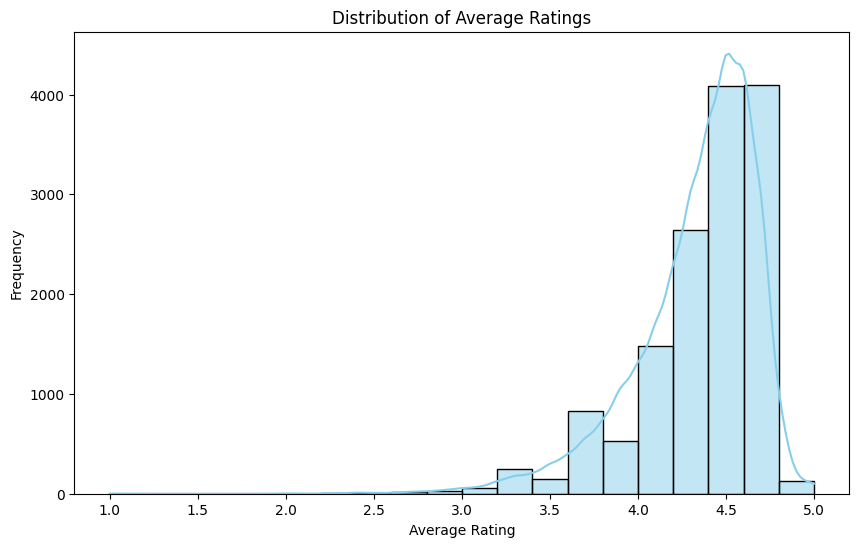

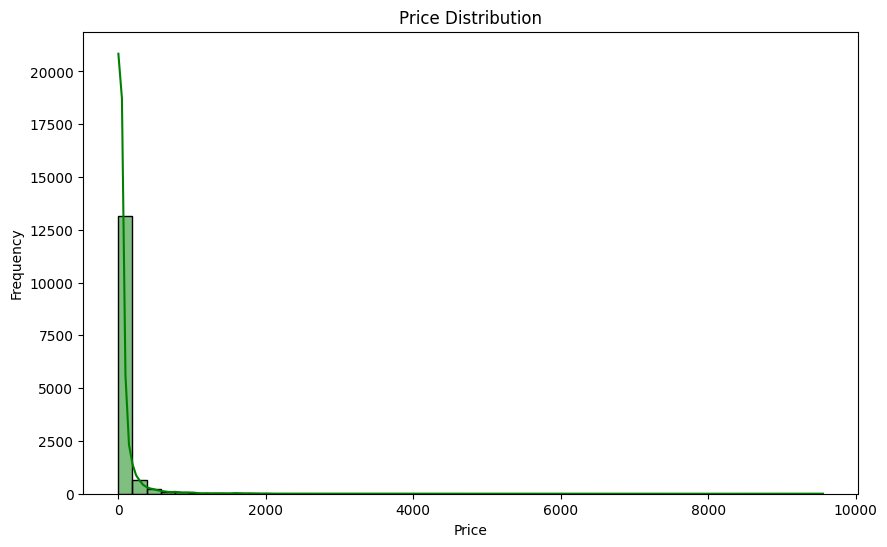

/tmp/ipykernel_92513/156131105.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')


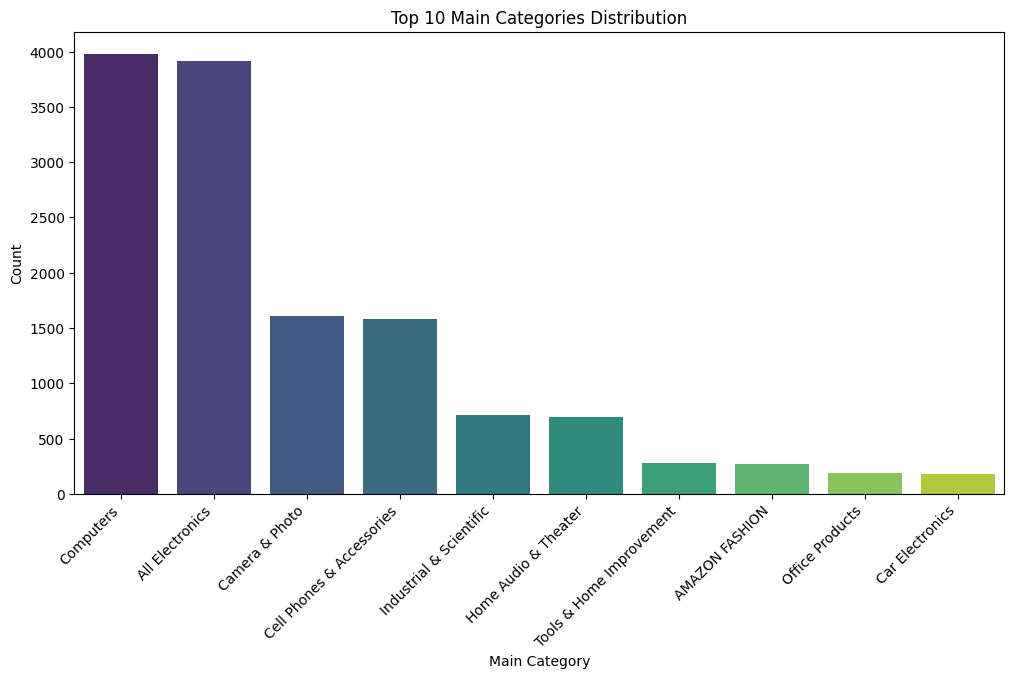

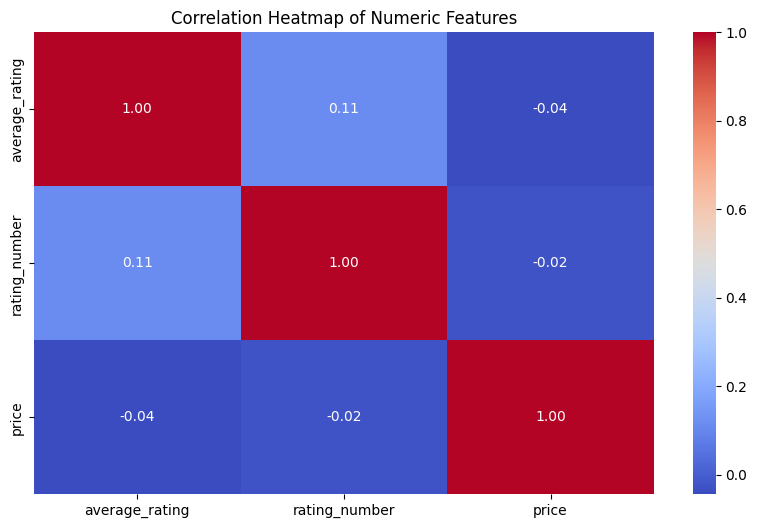

In [14]:
# 3. Distribution of `average_rating`
plt.figure(figsize=(10, 6))
sns.histplot(meta_df['average_rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# 4. Price Distribution (After cleaning missing prices)
plt.figure(figsize=(10, 6))
sns.histplot(meta_df['price'], bins=50, kde=True, color='green')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 5. Main Category Distribution (Top 10 categories)
plt.figure(figsize=(12, 6))
top_categories = meta_df['main_category'].value_counts().head(10)
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
plt.title('Top 10 Main Categories Distribution')
plt.xlabel('Main Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. Correlation heatmap (For numeric columns)
plt.figure(figsize=(10, 6))
corr = meta_df[['average_rating', 'rating_number', 'price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [15]:
# Numeric columns description
numeric_desc = meta_df.describe(include=[float, int])

# Categorical columns description
categorical_desc = meta_df.describe(include=[object])

# Display numeric statistics
print("\n----------- Numeric Features Overview -----------")
print(numeric_desc)

# Display categorical statistics
print("\n----------- Categorical Features Overview -----------")
print(categorical_desc)

KeyboardInterrupt: 

In [ ]:
meta_df.head(5)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
1,Computers,Digi-Tatoo Decal Skin Compatible With MacBook ...,4.5,246,[WARNING: Please IDENTIFY MODEL NUMBER on the ...,[],19.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'AL 2Sides Video', 'url': 'https://...",Digi-Tatoo,"[Electronics, Computers & Accessories, Laptop ...","{'Brand': 'Digi-Tatoo', 'Color': 'Fresh Marble...",B07SM135LS,None,NaN,NaN
2,AMAZON FASHION,NotoCity Compatible with Vivoactive 4 band 22m...,4.5,233,[☛NotoCity 22mm band is designed for Vivoactiv...,[],9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],NotoCity,"[Electronics, Wearable Technology, Clips, Arm ...","{'Date First Available': 'May 29, 2020', 'Manu...",B089CNGZCW,None,NaN,NaN
3,Cell Phones & Accessories,Motorola Droid X Essentials Combo Pack,3.8,64,"[New Droid X Essentials Combo Pack, Exclusive ...",[all Genuine High Quality Motorola Made Access...,14.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Verizon,"[Electronics, Computers & Accessories, Compute...",{'Product Dimensions': '11.6 x 6.9 x 3.1 inche...,B004E2Z88O,None,NaN,NaN
5,Cell Phones & Accessories,"QGHXO Band for Garmin Vivofit 4, Soft Silicone...",4.4,707,[Personalized Your Garmin Vivofit 4 Activity T...,"[Compatibility, Custom designed for your preci...",14.89,[{'thumb': 'https://m.media-amazon.com/images/...,[],QGHXO,"[Electronics, Wearable Technology, Arm & Wrist...",{'Package Dimensions': '6.85 x 4.37 x 1.1 inch...,B07BJ7ZZL7,None,NaN,NaN
6,None,"Fishfinder, Depth Finder Poly Sun Cover for 3""...",4.4,86,"[Made of poly material, Available in black, Dr...",[Affordable and convenient way to cover your s...,10.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Unboxing Gamin Vivid ', 'url': 'ht...",Westlake Market,"[Electronics, Car & Vehicle Electronics, Marin...",{'Item Package Dimensions L x W x H': '7.32 x ...,B00R6R82HS,None,NaN,NaN
